<a href="https://colab.research.google.com/github/DYNAFEM/REGRESION-PESO-BOVINOS/blob/MODELOS-MODALES-EN-SERIE/CNN%2BRF_MOD_SERIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Cargar Linrerias
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import r2_score
from tensorflow.keras import layers, models # Import models here
import cv2

In [ ]:
# Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.9 MB/s eta 0:00:00


 1) Imports, semilla y paths


--- INICIO ENTRENAMIENTO CNN ---
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 65611.0156 - mae: 246.7395 - r2_metric: -546.3951 - rmse_metric: 256.1227
Epoch 1: val_mae improved from inf to 260.75714, saving model to /content/drive/My Drive/REGRESION_PESO/checkpoints/CNN_REGRESSION.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - loss: 65719.2109 - mae: 246.7604 - r2_metric: -539.1188 - rmse_metric: 256.6714 - val_loss: 73245.7109 - val_mae: 260.7571 - val_r2_metric: -408.6449 - val_rmse_metric: 274.2326 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 59437.1953 - mae: 233.8661 - r2_metric: -581.6759 - rmse_metric: 242.8958
Epoch 2: val_mae did not improve from 260.75714
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - loss: 59406.1484 - mae: 233.6008 - r2_metric: -576.5905 - rmse_metric: 242.6922 - val_loss: 73478.9297 - val_mae: 261.2015 - val_r2_metric: -409.9566 - val_rmse_metric: 274.6621 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━

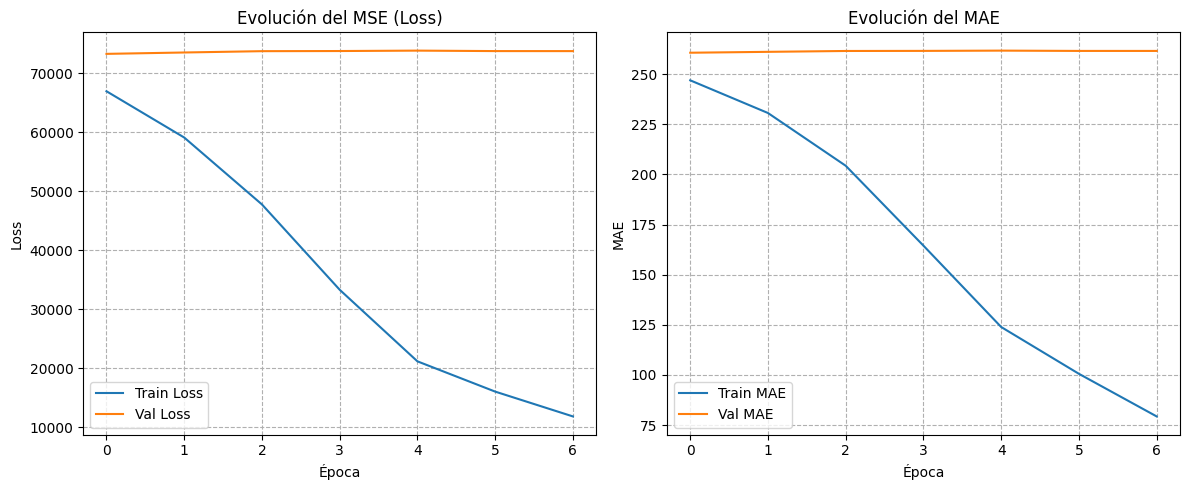

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step

--- Extracción de Embeddings ---
Train features: (326, 128) Train labels: (326,)
Val features: (82, 128) Val labels: (82,)
Test features: (102, 128) Test labels: (102,)

--- INICIO ENTRENAMIENTO RANDOM FOREST ---
--- ENTRENAMIENTO RF FINALIZADO ---

--- RESULTADOS RANDOM FOREST (Usando features del Test Set) ---
MSE : 4957.8186
RMSE: 70.4118
MAE : 46.4301
R²  : -0.1170


In [ ]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. CONFIGURACIÓN Y PREPARACIÓN DE DATOS ---

# Reproducibilidad
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# (Opcional) Configuración de GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("No se pudo configurar memory growth:", e)

# === Rutas provistas ===
# Asegúrate de que estas rutas son válidas en tu entorno
ruta_train  = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/train.csv"
ruta_val    = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/val.csv"
ruta_test   = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/test.csv"
ruta_imagenes = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/"

IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Función de carga del Dataset de TensorFlow
def cargar_dataset(csv_path, img_size=(224,224), batch_size=32, shuffle=True):
    df = pd.read_csv(csv_path)

    # Asume que 'filepath' ya incluye la ruta base (ruta_imagenes) o es relativa.
    # Si 'filepaths' son solo nombres de archivo, debes descomentar y ajustar:
    # filepaths = df["filename"].apply(lambda f: os.path.join(ruta_imagenes, f)).values
    filepaths = df["filepath"].values
    targets   = df["weight"].values.astype("float32")

    ds = tf.data.Dataset.from_tensor_slices((filepaths, targets))

    def procesar_imagen(ruta, label):
        img = tf.io.read_file(ruta)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0  # [0,1]
        return img, tf.cast(label, tf.float32)

    ds = ds.map(procesar_imagen, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Construcción de datasets
train_ds = cargar_dataset(ruta_train, img_size=IMG_SIZE, batch_size=32, shuffle=True)
val_ds   = cargar_dataset(ruta_val,   img_size=IMG_SIZE, batch_size=32, shuffle=False)
test_ds  = cargar_dataset(ruta_test,  img_size=IMG_SIZE, batch_size=32, shuffle=False)

# Definición de métricas personalizadas (necesarias para model.compile)
def rmse_metric(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def r2_metric(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - y_true_mean))
    return 1.0 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))

# --- 2. DEFINICIÓN DEL MODELO CNN (Extractor) ---

def build_simple_cnn_branch(
    final_dense_units=128, dropout=0.3, l2=1e-4, augment=True
):
    inputs = layers.Input(shape=INPUT_SHAPE, name="image_branch_input")
    x = inputs

    # Aumento de Datos (Si se desea)
    if augment:
        # Nota: Estas capas son parte del modelo Keras, se aplican SOLO durante el entrenamiento
        x = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ], name="data_augmentation")(x)

    # Bloques Convolucionales
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_1")(x)
    x = layers.BatchNormalization(name="bn_1")(x)
    x = layers.MaxPooling2D((2, 2), name="pool_1")(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="conv_2")(x)
    x = layers.BatchNormalization(name="bn_2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool_2")(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="conv_3")(x)
    x = layers.BatchNormalization(name="bn_3")(x)
    x = layers.MaxPooling2D((2, 2), name="pool_3")(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="conv_4")(x)
    x = layers.BatchNormalization(name="bn_4")(x)
    x = layers.MaxPooling2D((2, 2), name="pool_4")(x)

    # Cabeza de Salida de la Rama
    x = layers.GlobalAveragePooling2D(name="gap")(x) # Capa para extraer embeddings raw

    # Capa Densa (Feature Extractor)
    x = layers.Dense(
        final_dense_units,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2) if l2 else None,
        name="branch_dense_output"
    )(x)
    cnn_output = layers.Dropout(dropout, name="branch_dropout_output")(x)

    # Devolvemos la salida final de la rama (vector de embeddings)
    return models.Model(inputs=inputs, outputs=cnn_output, name="simple_cnn_branch")


# --- 3. CONSTRUCCIÓN DEL MODELO DE REGRESIÓN COMPLETO (Fase 1) ---

ckpt_dir = "/content/drive/My Drive/REGRESION_PESO/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

# Callbacks
early = callbacks.EarlyStopping(monitor="val_mae", patience=6, restore_best_weights=True)
reduce = callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
ckpt = callbacks.ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, "CNN_REGRESSION.keras"),
    monitor="val_mae", save_best_only=True, verbose=1
)

# Construir la rama CNN
cnn_branch = build_simple_cnn_branch(final_dense_units=128, dropout=0.5, l2=1e-4, augment=True) # Dropout aumentado a 0.5 para regularización

# Conectar la rama CNN con la capa de salida de regresión
inputs = tf.keras.Input(shape=INPUT_SHAPE, name='image_input')
x = cnn_branch(inputs) # Usar la rama como una capa
output = layers.Dense(1, activation='linear', name='prediction_output')(x)

model = models.Model(inputs=inputs, outputs=output, name='full_regression_model')

# Compilación (Usar un LR más alto para entrenamiento desde cero)
optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
             loss='mse',
             metrics=[rmse_metric, r2_metric, 'mae'])

print("\n--- INICIO ENTRENAMIENTO CNN ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Aumentado el número de epochs para entrenamiento 'from scratch'
    callbacks=[early, reduce, ckpt],
    verbose=1
)
print("--- ENTRENAMIENTO CNN FINALIZADO ---\n")

# --- 4. VISUALIZACIÓN ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del MSE (Loss)')
plt.xlabel('Época'); plt.ylabel('Loss'); plt.legend(); plt.grid(linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Evolución del MAE')
plt.xlabel('Época'); plt.ylabel('MAE'); plt.legend(); plt.grid(linestyle='--')
plt.tight_layout(); plt.show()


# --- 5. EXTRACCIÓN DE FEATURES (Fase 2) ---

# CRITICAL CORRECTION: El extractor se construye a partir del modelo ENTRENADO ('model')
# y apunta a la capa de salida de embeddings deseada.
feature_extractor = cnn_branch

# Función CORREGIDA para extraer features y labels (más eficiente con .predict)
def extract_features_labels(dataset, extractor):
    # 1. Extraer features directamente del dataset
    features = extractor.predict(dataset, verbose=1)

    # 2. Extraer labels del dataset
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0)

    return features, labels

X_train, y_train = extract_features_labels(train_ds, feature_extractor)
X_val, y_val = extract_features_labels(val_ds, feature_extractor)
X_test, y_test = extract_features_labels(test_ds, feature_extractor) # Extracción del set de prueba

print("\n--- Extracción de Embeddings ---")
print("Train features:", X_train.shape, "Train labels:", y_train.shape)
print("Val features:", X_val.shape, "Val labels:", y_val.shape)
print("Test features:", X_test.shape, "Test labels:", y_test.shape)


# --- 6. RANDOM FOREST REGRESSOR ---

print("\n--- INICIO ENTRENAMIENTO RANDOM FOREST ---")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("--- ENTRENAMIENTO RF FINALIZADO ---")

# --- 7. EVALUACIÓN FINAL ---

# Predicción en el set de prueba (X_test)
y_pred = rf.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- RESULTADOS RANDOM FOREST (Usando features del Test Set) ---")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

In [ ]:
# --- 7. EVALUACIÓN FINAL ---

# Predicción en el set de prueba (X_test)
y_pred = rf.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- RESULTADOS RANDOM FOREST (Usando features del Test Set) ---")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


--- RESULTADOS RANDOM FOREST (Usando features del Test Set) ---
MSE : 4957.8186
RMSE: 70.4118
MAE : 46.4301
R²  : -0.1170


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Genera gráficas de Loss (Pérdida) y MAE (Error Absoluto Medio)
    para el conjunto de entrenamiento y validación.

    Args:
        history (tensorflow.keras.callbacks.History): Objeto devuelto por model.fit().
    """

    # --- Gráfica 1: Evolución del Loss (MSE) ---
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    # Se usa 'loss' que por defecto es el MSE en tu modelo
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Evolución de la Pérdida (Loss)')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--')

    # --- Gráfica 2: Evolución del MAE ---
    plt.subplot(1, 2, 2)
    # Se usa 'mae'
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Evolución del Error Absoluto Medio (MAE)')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.tight_layout() # Ajusta automáticamente los subplots
    plt.show()

# --- USO ---
# Asumiendo que 'history' es el objeto devuelto por model.fit(...)
# plot_training_history(history)